In [ ]:
#!pip install wordcloud

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from collections import Counter
import string
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense,Bidirectional, Dropout, Attention, BatchNormalization, LeakyReLU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp /content/drive/MyDrive/data/Resume.csv /content/
!cp /content/drive/MyDrive/data/glove.6B.300d.txt /content/
!cp /content/drive/MyDrive/data/glove.6B.100d.txt /content/

Mounted at /content/drive


In [ ]:
data = pd.read_csv(r"Resume.csv")

data.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


## Exploratory Data Analysis

In [ ]:
#Checking the length of the resume
data['resume_len']=data['Resume_str'].apply(len)

In [ ]:
data['resume_len'].describe() #The min. number of character is 21, which possibly indicates an outlier

count     2484.000000
mean      6295.308776
std       2769.251458
min         21.000000
25%       5160.000000
50%       5886.500000
75%       7227.250000
max      38842.000000
Name: resume_len, dtype: float64

In [ ]:
data[data['resume_len']==21]['Resume_str'].values #Output is 'space' character
data=data[data['resume_len']!=21] #Remove the record with minimum length. Record with max. length is okay, it can be kept

In [ ]:
data[data['resume_len']==38842]['Resume_str'].values

array(['         CHEF       Credentials     National Registry of Food Safety Professionals Certified Food Safety Manager  National Registry of Food Safety Professionals Test Administrator/Proctor       Education and Training      High School Diploma     Jun 1991     Newington High School   －   City  ,   State            Summary    Passionate Chef with broad background in various culinary styles and positions. A natural leader with excellent interpersonal communication skills and the ability to get things done overcoming any obstacles.\xa0      Accomplishments     Voted Best Restaurant 2013  Multiple "Best Of" accolades       Experience      Chef     Oct 2016   to   Current      Company Name   －   City  ,   State      \xa0All aspects of an independently operated Hospital kitchen including staffing, payroll, menus, inventory/ordering, P&L, employee training and discipline, cleaning and equipment maintenance.      Monitor p&l and food and labor costs to maximize budget and minimize waste.

In [ ]:
data['Category'].value_counts()

Category
INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      119
FINANCE                   118
ADVOCATE                  118
ACCOUNTANT                118
ENGINEERING               118
CHEF                      118
AVIATION                  117
FITNESS                   117
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: count, dtype: int64

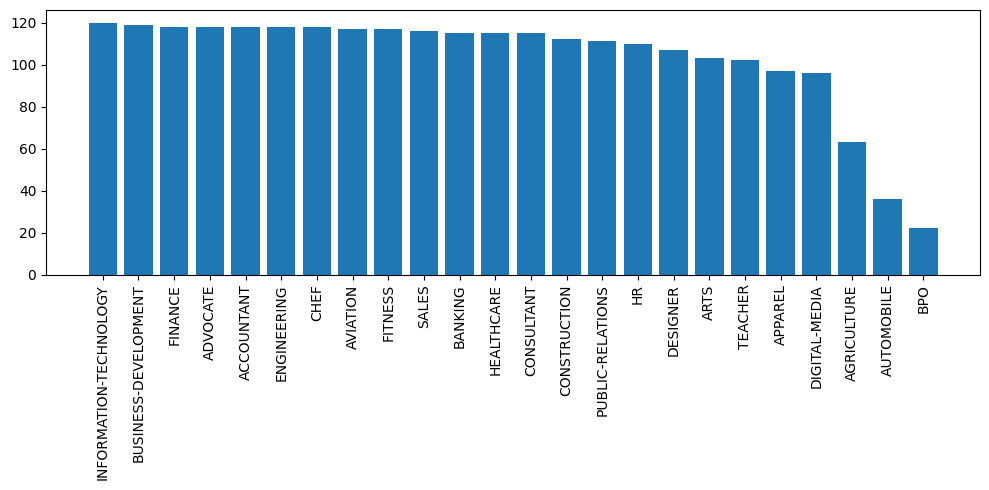

In [ ]:
#Checking the distribution of the Categories
fig= plt.figure(figsize=(10,5))
plt.bar(x=data['Category'].value_counts().index,
        height=data['Category'].value_counts().values)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



In [ ]:
#Checking the average lenght of a resume for each Category
data.groupby(by='Category')['resume_len'].mean().sort_values(ascending=False)

Category
BPO                       7317.681818
INFORMATION-TECHNOLOGY    7227.550000
HEALTHCARE                6996.182609
PUBLIC-RELATIONS          6913.432432
CONSULTANT                6844.347826
HR                        6760.763636
CONSTRUCTION              6618.455357
AGRICULTURE               6605.285714
ADVOCATE                  6575.161017
ENGINEERING               6476.033898
AUTOMOBILE                6321.250000
FINANCE                   6316.161017
ACCOUNTANT                6293.508475
BANKING                   6191.191304
AVIATION                  6189.205128
DIGITAL-MEDIA             6094.729167
BUSINESS-DEVELOPMENT      6094.588235
APPAREL                   6030.123711
ARTS                      6000.368932
CHEF                      5995.542373
DESIGNER                  5647.233645
FITNESS                   5586.803419
TEACHER                   5562.803922
SALES                     5270.034483
Name: resume_len, dtype: float64

In [ ]:
#Create a new column and write the most frequent word for each resume
def most_frequent_word(text):
    # Tokenize the text into words
    words = nltk.word_tokenize(text)
    # Filter out stopwords and punctuation
    stop_words = set(stopwords.words('english'))
    punctuation = set(string.punctuation)
    filtered_words = [word.lower() for word in words if word.lower() not in stop_words and word.lower() not in punctuation]
    # Count the frequency of each word
    word_counts = Counter(filtered_words)
    # Find the most common word
    most_common_word, frequency = word_counts.most_common(1)[0]
    return most_common_word, frequency

In [ ]:
#!pip install nltk

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# data['Most_frequent_word'], data['Frequency'] = zip(*data['Resume_str'].apply(most_frequent_word))
data['Most_frequent_word'], data['Frequency'] = zip(*data['Resume_str'].apply(most_frequent_word))


In [ ]:
data.head()

,ID,Resume_str,Resume_html,Category,resume_len,Most_frequent_word,Frequency
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR,5442,customer,12
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR,5572,marketing,12
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR,7720,management,16
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR,2855,customer,7
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR,9172,hr,32


In [ ]:
#Top 10 most frequent word used in all dataset
data['Most_frequent_word'].value_counts().head(10)

Most_frequent_word
sales         165
customer      132
management    117
company        75
financial      73
state          69
marketing      65
business       63
city           51
accounting     51
Name: count, dtype: int64

In [ ]:
# Function to generate word cloud for a given text
def generate_word_cloud(ax, text, category):
    # Tokenize the text into words
    words = nltk.word_tokenize(text)
    # Filter out stopwords and punctuation
    stop_words = set(stopwords.words('english'))
    punctuation = set(string.punctuation)
    filtered_words = [word.lower() for word in words if word.lower() not in stop_words and word.lower() not in punctuation]
    # Create word cloud
    wordcloud = WordCloud(width=200, height=100, background_color='white').generate(' '.join(filtered_words))
    # Plot word cloud
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(category)
    ax.axis('off')


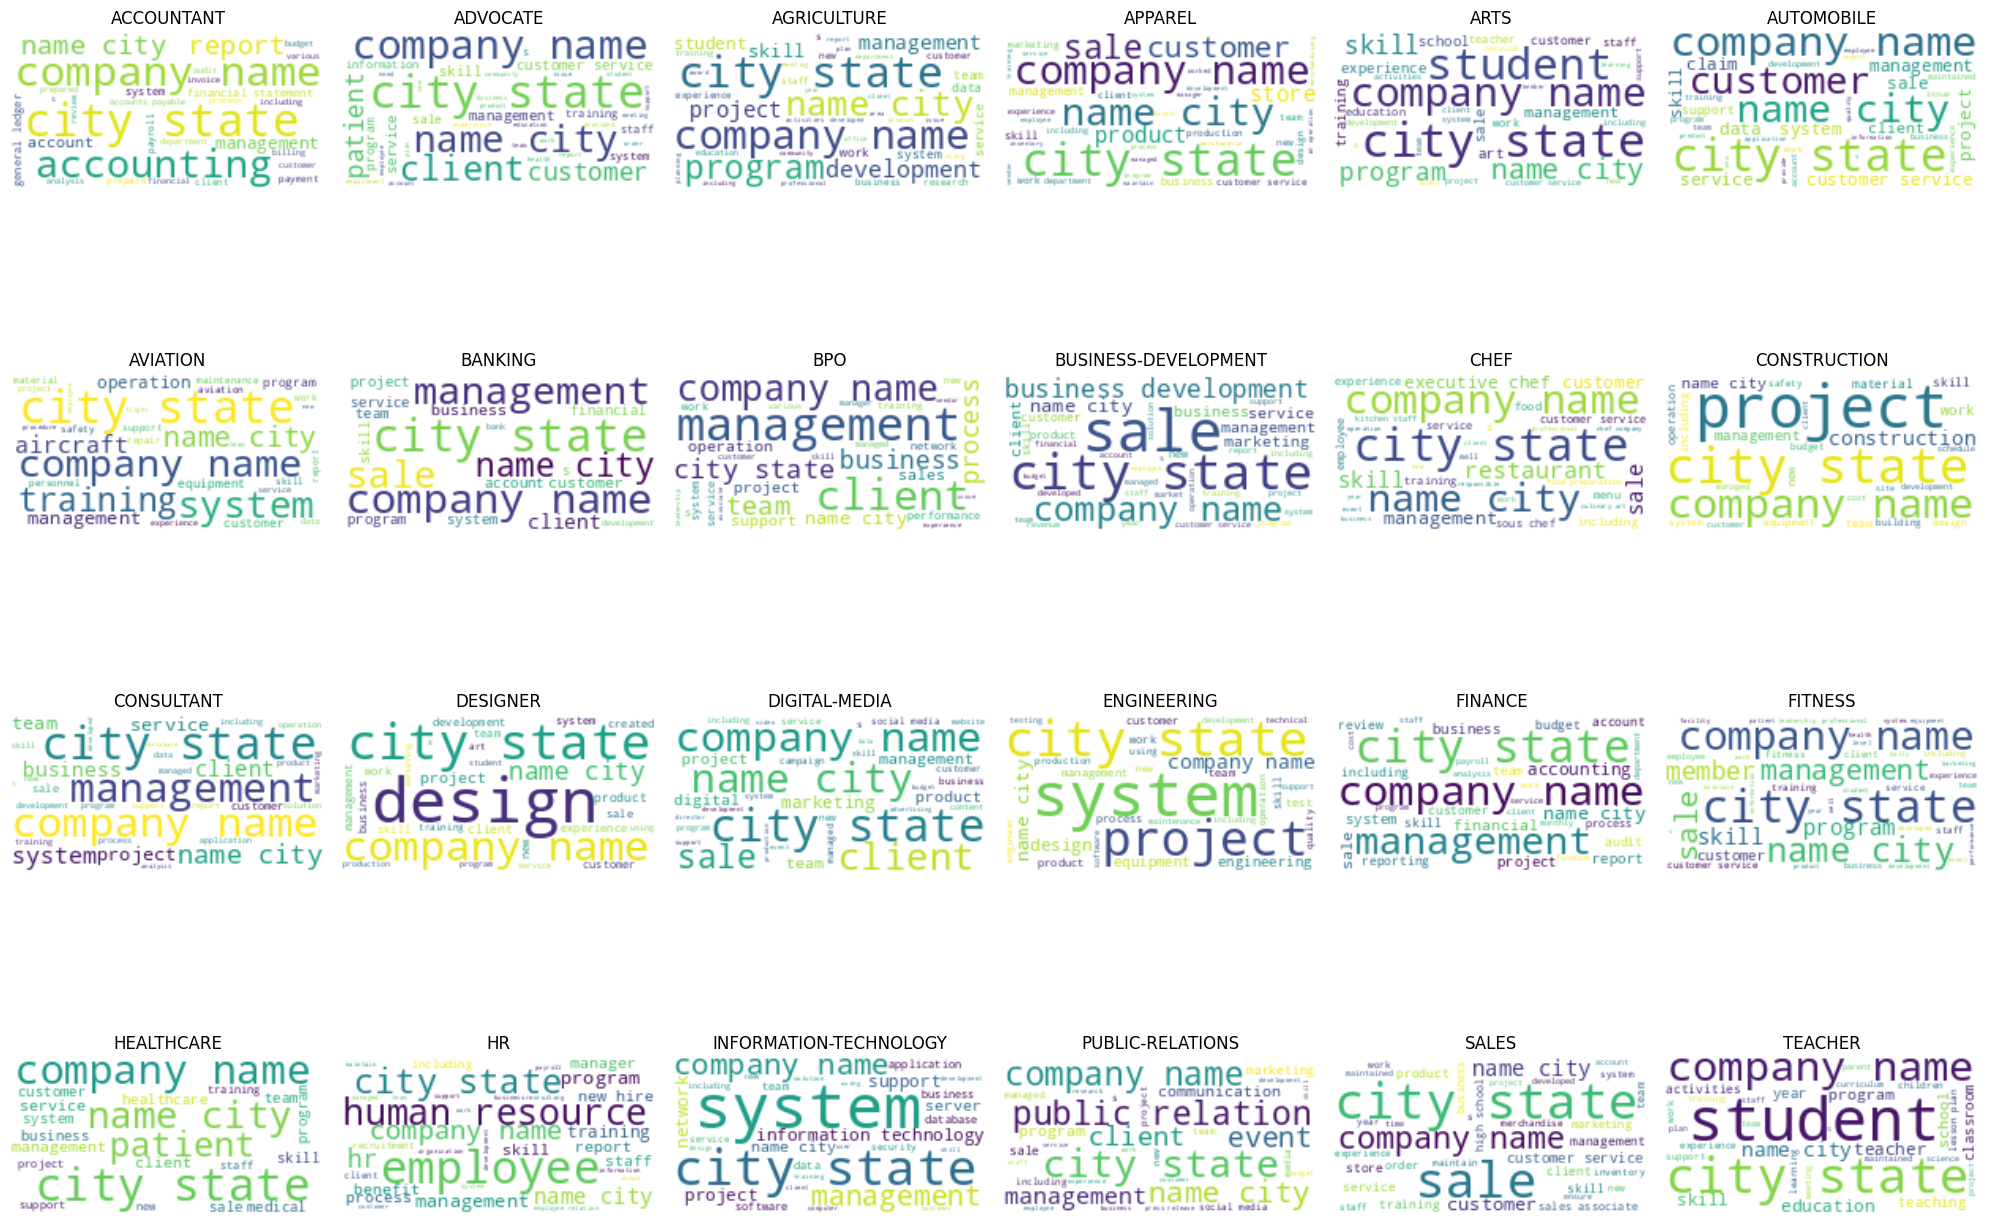

In [ ]:
fig, axs = plt.subplots(4, 6, figsize=(20, 15))

# Generate word clouds for each category
for i, (category, group) in enumerate(data.groupby('Category')):
    ax = axs[i // 6, i % 6]
    generate_word_cloud(ax, ' '.join(group['Resume_str']), category)

# Hide empty subplots
for i in range(len(data['Category']), 4*6):
    axs[i // 6, i % 6].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

Some of the words are not related with the position, but a regular content of a resume, such as 'City', 'State'.

Optional: A keyword list can be created and removed from the resume to clean the data

## Data Preprocessing

In [ ]:
# Filter out stopwords and punctuation
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

In [ ]:
def remove_punc_stopwords(text):
    # Tokenize the text into words
    words = nltk.word_tokenize(text)
    filtered_words = [word.lower() for word in words if word.lower() not in stop_words and word.lower() not in punctuation]
    return filtered_words
    # Create word cloud

In [ ]:
data['cleaned_resume']=data['Resume_str'].apply(remove_punc_stopwords)

In [ ]:
keywords=['city','state','company','name']

In [ ]:
#Removes words in the keywords list from cleaned_resume column
def remove_keywords(words_list):
    return [word for word in words_list if word.lower() not in keywords]

In [ ]:
data['cleaned_resume'] = data['cleaned_resume'].apply(remove_keywords)

In [ ]:
data.head()

,ID,Resume_str,Resume_html,Category,resume_len,Most_frequent_word,Frequency,cleaned_resume
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR,5442,customer,12,"[hr, administrator/marketing, associate, hr, a..."
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR,5572,marketing,12,"[hr, specialist, us, hr, operations, summary, ..."
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR,7720,management,16,"[hr, director, summary, 20, years, experience,..."
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR,2855,customer,7,"[hr, specialist, summary, dedicated, driven, d..."
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR,9172,hr,32,"[hr, manager, skill, highlights, hr, skills, h..."


In [ ]:
#This function will remove the category names from the beginning of the resume. It will make the model more robust, because instead of memorizing the category name, they will be categorized based on their content
def remove_category_name(row):
    category_name = row['Category']
    #category_words = category_name.split()
    resume_str = row['cleaned_resume']
    # If the first 5 words contain the category name, remove them
    return [word for word in resume_str if category_name.lower() != word]


In [ ]:
data['cleaned_resume'] = data.apply(remove_category_name, axis=1)

In [ ]:
data['cleaned_resume_full'] = data['cleaned_resume'].apply(lambda x: ' '.join(x))

In [ ]:
num_of_words = len(list(set(data['cleaned_resume_full'])))
num_of_words

2481

In [ ]:
label_encoder = LabelEncoder()
data['encoded_category'] = label_encoder.fit_transform(data['Category'])

In [ ]:
data.head()

,ID,Resume_str,Resume_html,Category,resume_len,Most_frequent_word,Frequency,cleaned_resume,cleaned_resume_full,encoded_category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR,5442,customer,12,"[administrator/marketing, associate, administr...",administrator/marketing associate administrato...,19
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR,5572,marketing,12,"[specialist, us, operations, summary, versatil...",specialist us operations summary versatile med...,19
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR,7720,management,16,"[director, summary, 20, years, experience, rec...",director summary 20 years experience recruitin...,19
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR,2855,customer,7,"[specialist, summary, dedicated, driven, dynam...",specialist summary dedicated driven dynamic 20...,19
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR,9172,hr,32,"[manager, skill, highlights, skills, departmen...",manager skill highlights skills department sta...,19


In [ ]:
from keras.utils import to_categorical


num_classes = 24  # Total number of labels

# One-hot encode the 'Category' column
data['one_hot_target'] = data['encoded_category'].apply(lambda x: to_categorical(x, num_classes=num_classes).tolist())

# Convert the list of one-hot encoded vectors to a single string representation
data['one_hot_target'] = data['one_hot_target'].apply(lambda x: np.array(x))


In [ ]:
data.head()

,ID,Resume_str,Resume_html,Category,resume_len,Most_frequent_word,Frequency,cleaned_resume,cleaned_resume_full,encoded_category,one_hot_target
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR,5442,customer,12,"[administrator/marketing, associate, administr...",administrator/marketing associate administrato...,19,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR,5572,marketing,12,"[specialist, us, operations, summary, versatil...",specialist us operations summary versatile med...,19,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR,7720,management,16,"[director, summary, 20, years, experience, rec...",director summary 20 years experience recruitin...,19,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR,2855,customer,7,"[specialist, summary, dedicated, driven, dynam...",specialist summary dedicated driven dynamic 20...,19,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR,9172,hr,32,"[manager, skill, highlights, skills, departmen...",manager skill highlights skills department sta...,19,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Lemmatization

In [ ]:
# For spaCy
import spacy
nlp = spacy.load("en_core_web_sm")  # Load the English language model

In [ ]:
# Example with NLTK
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet

def lemmatize_text(text):
  """
  This function takes a string of text and returns the lemmatized version.
  """
  doc = nlp(text)
  lemmas = [token.lemma_ for token in doc]
  return " ".join(lemmas)

In [ ]:
data['lemmatized_resume'] = data['cleaned_resume_full'].apply(lemmatize_text)

In [ ]:
data.head()

,ID,Resume_str,Resume_html,Category,resume_len,Most_frequent_word,Frequency,cleaned_resume,cleaned_resume_full,encoded_category,one_hot_target,lemmatized_resume
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR,5442,customer,12,"[administrator/marketing, associate, administr...",administrator/marketing associate administrato...,19,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",administrator / marketing associate administra...
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR,5572,marketing,12,"[specialist, us, operations, summary, versatil...",specialist us operations summary versatile med...,19,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",specialist we operation summary versatile medi...
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR,7720,management,16,"[director, summary, 20, years, experience, rec...",director summary 20 years experience recruitin...,19,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",director summary 20 year experience recruit 15...
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR,2855,customer,7,"[specialist, summary, dedicated, driven, dynam...",specialist summary dedicated driven dynamic 20...,19,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",specialist summary dedicate drive dynamic 20 y...
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR,9172,hr,32,"[manager, skill, highlights, skills, departmen...",manager skill highlights skills department sta...,19,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",manager skill highlight skill department start...


## Model Preparation

In [ ]:
X=data['lemmatized_resume']
y=data['one_hot_target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
y_train = np.array(y_train)
y_test = np.array(y_test)
X_train = np.array(X_train)
X_test = np.array(X_test)

In [ ]:
tokenizer = Tokenizer(num_words = num_of_words )
tokenizer.fit_on_texts(X_train)
X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)

In [ ]:
# Padding
max_len = max(len(seq) for seq in X)
X_train_padded = pad_sequences(X_train_token, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_token, maxlen=max_len, padding='post')

In [ ]:
X_train_padded_tf = tf.convert_to_tensor(X_train_padded)
X_test_padded_tf = tf.convert_to_tensor(X_test_padded)

y_train_flat = np.array(y_train).flatten().tolist()
y_test_flat = np.array(y_test).flatten().tolist()

y_train_tf = tf.constant(y_train_flat)
y_test_tf = tf.constant(y_test_flat)

In [ ]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, SpatialDropout1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model

# Define the model
inputs = Input(shape=(max_len,))
x = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_len)(inputs)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)
outputs = Dense(24, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26774)]           0         
                                                                 
 embedding_2 (Embedding)     (None, 26774, 128)        4051200   
                                                                 
 spatial_dropout1d (Spatial  (None, 26774, 128)        0         
 Dropout1D)                                                      
                                                                 
 bidirectional_2 (Bidirecti  (None, 26774, 256)        263168    
 onal)                                                           
                                                                 
 global_max_pooling1d (Glob  (None, 256)               0         
 alMaxPooling1D)                                                 
                                                             

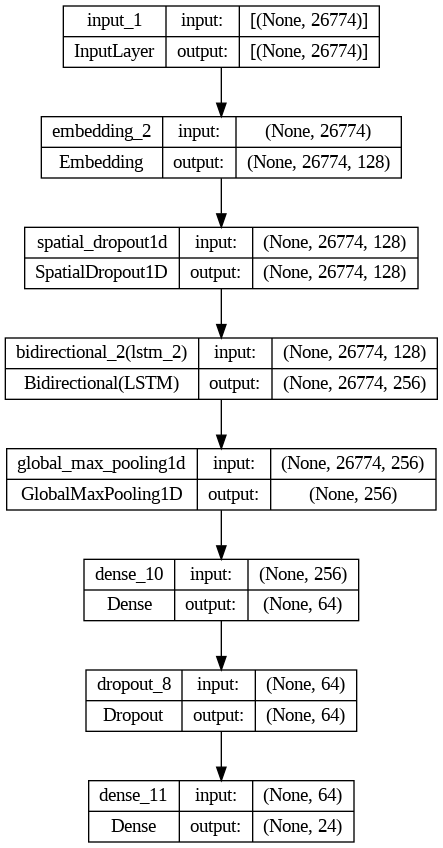

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
model.fit(X_train_padded_tf, y_train_tf, epochs=40, batch_size=32, validation_split=0.2)
#history = model.fit(X_train_padded, y_train, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/40
50/50 [==============================] - 117s 2s/step - loss: 0.3451 - accuracy: 0.0346 - val_loss: 0.1772 - val_accuracy: 0.0528
Epoch 2/40
50/50 [==============================] - 105s 2s/step - loss: 0.1931 - accuracy: 0.0416 - val_loss: 0.1726 - val_accuracy: 0.0528
Epoch 3/40
50/50 [==============================] - 104s 2s/step - loss: 0.1860 - accuracy: 0.0523 - val_loss: 0.1721 - val_accuracy: 0.0628
Epoch 4/40
50/50 [==============================] - 103s 2s/step - loss: 0.1836 - accuracy: 0.0472 - val_loss: 0.1718 - val_accuracy: 0.0276
Epoch 5/40
50/50 [==============================] - 102s 2s/step - loss: 0.1818 - accuracy: 0.0435 - val_loss: 0.1724 - val_accuracy: 0.0628
Epoch 6/40
50/50 [==============================] - 102s 2s/step - loss: 0.1799 - accuracy: 0.0579 - val_loss: 0.1700 - val_accuracy: 0.1156
Epoch 7/40
50/50 [==============================] - 100s 2s/step - loss: 0.1752 - accuracy: 0.0712 - val_loss: 0.1689 - val_accuracy: 0.0653
Epoch 8/40
50

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Make predictions on the test data
predictions = model.predict(X_test_padded_tf)

# Convert the predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test_flat, axis = 1)


16/16 [==============================] - 13s 788ms/step


In [ ]:
# Calculate evaluation metrics
accuracy = np.mean(predicted_labels == true_labels)
print("Accuracy:", accuracy)


Accuracy: 0.4164989939637827


In [ ]:
true_labels_decoded = label_encoder.inverse_transform(true_labels)
predicted_labels_decoded = label_encoder.inverse_transform(predicted_labels)

Classification Report:
                        precision    recall  f1-score   support

            ACCOUNTANT       0.59      0.57      0.58        28
              ADVOCATE       0.14      0.10      0.12        30
           AGRICULTURE       0.00      0.00      0.00        10
               APPAREL       0.14      0.07      0.10        14
                  ARTS       0.20      0.17      0.18        18
            AUTOMOBILE       0.00      0.00      0.00         5
              AVIATION       0.80      0.50      0.62        24
               BANKING       0.19      0.44      0.26        16
                   BPO       0.00      0.00      0.00         3
  BUSINESS-DEVELOPMENT       0.95      0.78      0.86        23
                  CHEF       0.87      0.87      0.87        31
          CONSTRUCTION       0.35      0.41      0.38        32
            CONSULTANT       0.22      0.22      0.22        23
              DESIGNER       0.53      0.53      0.53        19
         DIGITAL

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


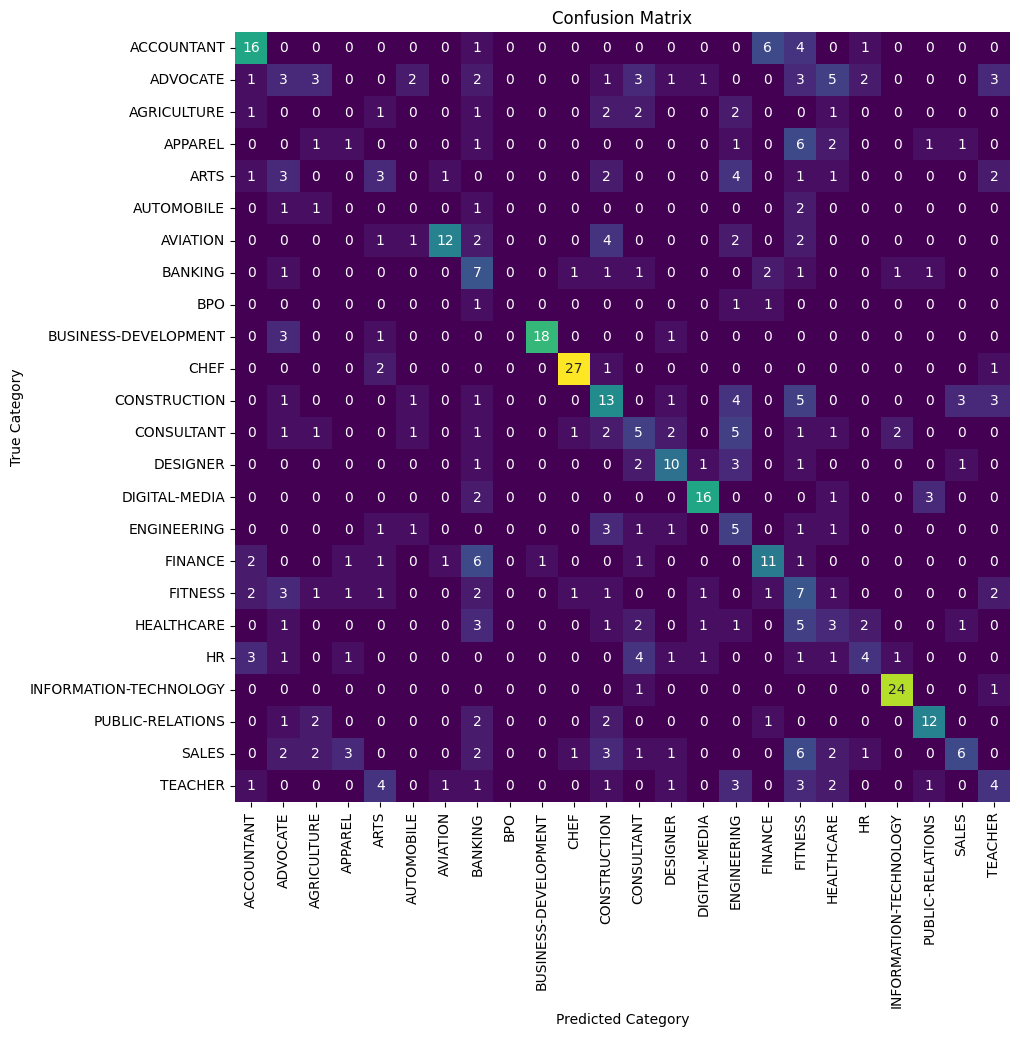

In [ ]:
# Generate classification report
print("Classification Report:")
print(classification_report(true_labels_decoded, predicted_labels_decoded))

conf_matrix = confusion_matrix(true_labels_decoded, predicted_labels_decoded)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='viridis', cbar=False)
plt.xlabel('Predicted Category')
plt.ylabel('True Category')
plt.title('Confusion Matrix')
plt.show()

## Transfer Learning

In [ ]:
from tensorflow.keras.initializers import Constant

# Load pre-trained word embeddings (GloVe in this example)
# Assuming you have GloVe embeddings stored in a file 'glove.6B.100d.txt'
embedding_dim = 100
embeddings_index = {}
with open(r"/content/glove.6B.100d.txt", encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs



In [ ]:
# Map words to embeddings
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [ ]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, SpatialDropout1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model

# Define the model
inputs = Input(shape=(max_len,))
x = Embedding(input_dim=len(tokenizer.word_index) + 1,
                    output_dim=embedding_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=max_len,
                    trainable=False)(inputs)  # Freeze embedding layer
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)
outputs = Dense(24, activation='softmax')(x)

model_tl = Model(inputs=inputs, outputs=outputs)

In [ ]:
model_tl.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
model_tl.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 26774)]           0         
                                                                 
 embedding_4 (Embedding)     (None, 26774, 100)        3165000   
                                                                 
 spatial_dropout1d_1 (Spati  (None, 26774, 100)        0         
 alDropout1D)                                                    
                                                                 
 bidirectional_4 (Bidirecti  (None, 26774, 256)        234496    
 onal)                                                           
                                                                 
 global_max_pooling1d_1 (Gl  (None, 256)               0         
 obalMaxPooling1D)                                               
                                                           

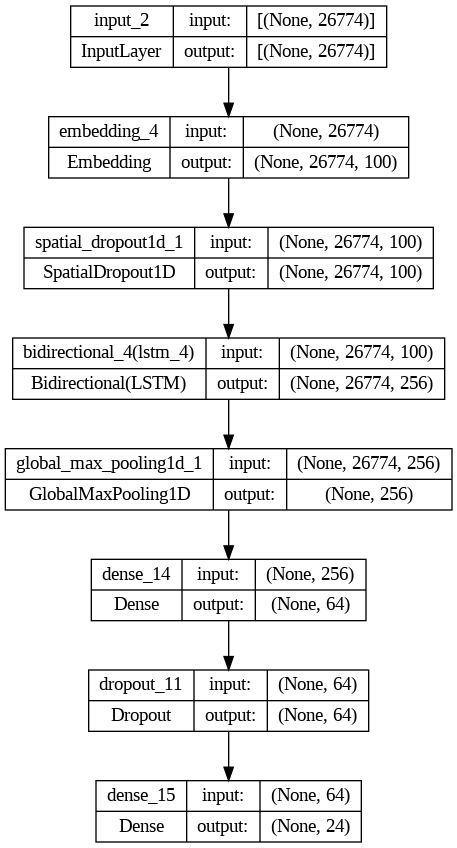

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_tl, to_file='model_transfer100_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
model_tl.fit(X_train_padded_tf, y_train_tf, epochs=40, batch_size=32, validation_split=0.2)
#history = model.fit(X_train_padded, y_train, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/40
50/50 [==============================] - 105s 2s/step - loss: 0.2814 - accuracy: 0.0403 - val_loss: 0.1752 - val_accuracy: 0.0352
Epoch 2/40
50/50 [==============================] - 97s 2s/step - loss: 0.1905 - accuracy: 0.0516 - val_loss: 0.1706 - val_accuracy: 0.0754
Epoch 3/40
50/50 [==============================] - 95s 2s/step - loss: 0.1835 - accuracy: 0.0523 - val_loss: 0.1682 - val_accuracy: 0.1181
Epoch 4/40
50/50 [==============================] - 96s 2s/step - loss: 0.1786 - accuracy: 0.0863 - val_loss: 0.1646 - val_accuracy: 0.1608
Epoch 5/40
50/50 [==============================] - 96s 2s/step - loss: 0.1729 - accuracy: 0.1089 - val_loss: 0.1575 - val_accuracy: 0.2940
Epoch 6/40
50/50 [==============================] - 94s 2s/step - loss: 0.1642 - accuracy: 0.1555 - val_loss: 0.1533 - val_accuracy: 0.2613
Epoch 7/40
50/50 [==============================] - 97s 2s/step - loss: 0.1573 - accuracy: 0.2040 - val_loss: 0.1433 - val_accuracy: 0.3492
Epoch 8/40
50/50 [=

In [ ]:
# Make predictions on the test data
predictions_tl100 = model_tl.predict(X_test_padded_tf)

# Convert the predictions to class labels
predicted_labels_tl100 = np.argmax(predictions_tl100, axis=1)
true_labels = np.argmax(y_test_flat, axis = 1)


16/16 [==============================] - 12s 647ms/step


In [ ]:
# Calculate evaluation metrics
accuracy_tl100 = np.mean(predicted_labels_tl100 == true_labels)
print("Accuracy:", accuracy_tl100)


Accuracy: 0.6680080482897385


In [ ]:
true_labels_decoded = label_encoder.inverse_transform(true_labels)
predicted_labels_decoded_tl100 = label_encoder.inverse_transform(predicted_labels_tl100)

Classification Report:
                        precision    recall  f1-score   support

            ACCOUNTANT       0.87      0.93      0.90        28
              ADVOCATE       0.62      0.43      0.51        30
           AGRICULTURE       0.25      0.10      0.14        10
               APPAREL       0.55      0.43      0.48        14
                  ARTS       0.47      0.50      0.49        18
            AUTOMOBILE       0.00      0.00      0.00         5
              AVIATION       0.82      0.58      0.68        24
               BANKING       0.69      0.56      0.62        16
                   BPO       0.00      0.00      0.00         3
  BUSINESS-DEVELOPMENT       1.00      1.00      1.00        23
                  CHEF       0.81      0.84      0.83        31
          CONSTRUCTION       0.63      0.81      0.71        32
            CONSULTANT       0.57      0.70      0.63        23
              DESIGNER       0.74      0.89      0.81        19
         DIGITAL

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


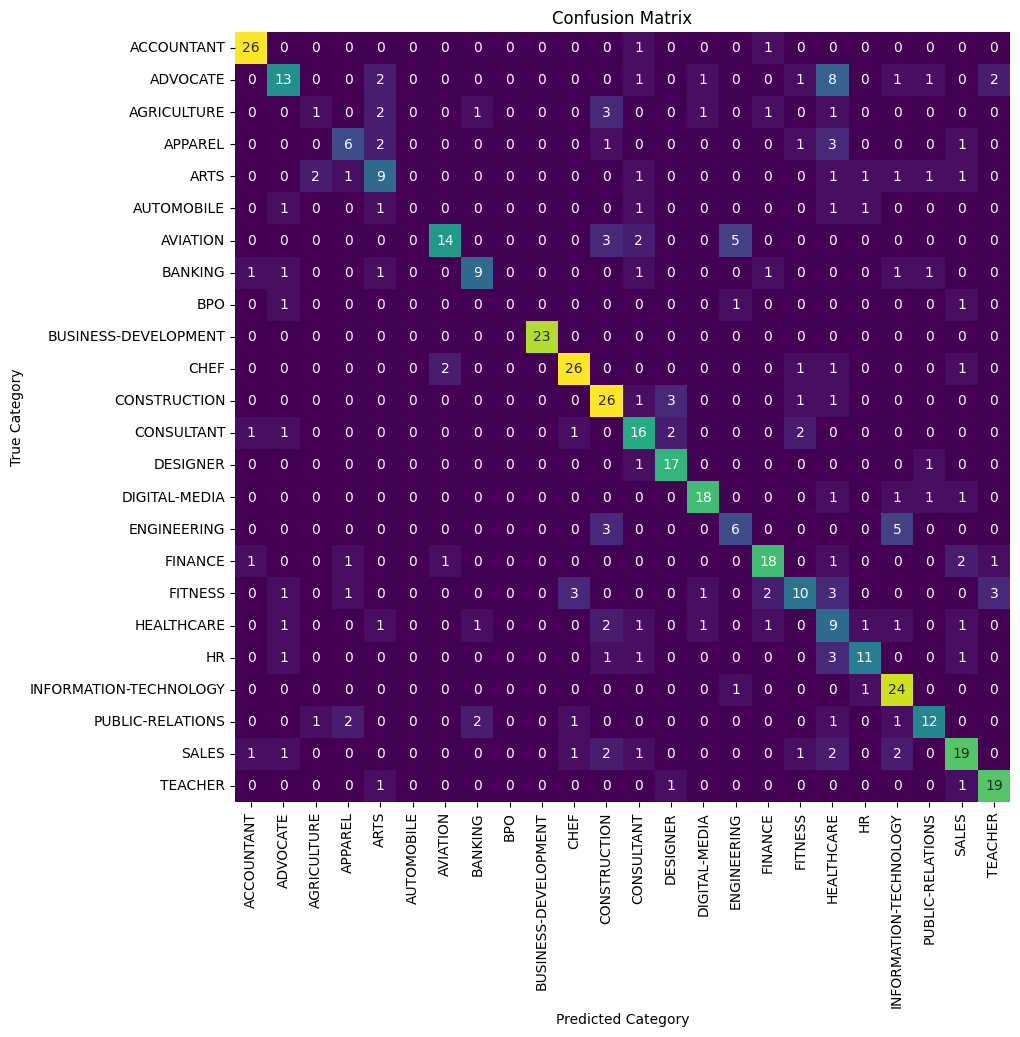

In [ ]:
# Generate classification report
print("Classification Report:")
print(classification_report(true_labels_decoded, predicted_labels_decoded_tl100))

conf_matrix_tl100 = confusion_matrix(true_labels_decoded, predicted_labels_decoded_tl100)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix_tl100, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='viridis', cbar=False)
plt.xlabel('Predicted Category')
plt.ylabel('True Category')
plt.title('Confusion Matrix')
plt.show()


### Alternative Transfer Learning

In [ ]:
from tensorflow.keras.initializers import Constant
# Load pre-trained word embeddings (GloVe in this example)
# Assuming you have GloVe embeddings stored in a file 'glove.6B.100d.txt'
embedding_dim = 300
embeddings_index = {}
with open(r"/content/glove.6B.300d.txt", encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs


In [ ]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, SpatialDropout1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model

# Map words to embeddings
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


# Define the model
inputs = Input(shape=(max_len,))
x = Embedding(input_dim=len(tokenizer.word_index) + 1,
                    output_dim=embedding_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=max_len,
                    trainable=False)(inputs)  # Freeze embedding layer
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)
outputs = Dense(24, activation='softmax')(x)

model_tl300 = Model(inputs=inputs, outputs=outputs)



In [ ]:
model_tl300.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_tl300.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 26774)]           0         
                                                                 
 embedding (Embedding)       (None, 26774, 300)        9495000   
                                                                 
 spatial_dropout1d (Spatial  (None, 26774, 300)        0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 26774, 256)        439296    
 al)                                                             
                                                                 
 global_max_pooling1d (Glob  (None, 256)               0         
 alMaxPooling1D)                                                 
                                                             

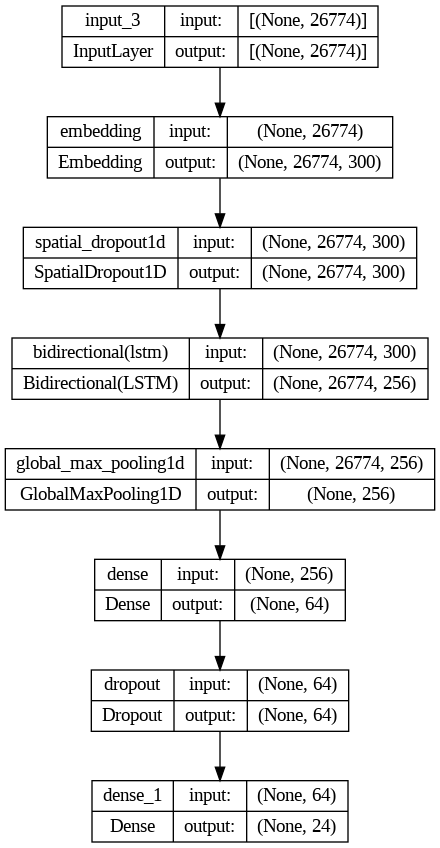

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_tl300, to_file='model_transfer300_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
model_tl300.fit(X_train_padded_tf, y_train_tf, epochs=35, batch_size=32, validation_split=0.2)
#history = model.fit(X_train_padded, y_train, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/35
50/50 [==============================] - 137s 2s/step - loss: 0.3235 - accuracy: 0.0491 - val_loss: 0.1733 - val_accuracy: 0.0302
Epoch 2/35
50/50 [==============================] - 102s 2s/step - loss: 0.1978 - accuracy: 0.0560 - val_loss: 0.1670 - val_accuracy: 0.1759
Epoch 3/35
50/50 [==============================] - 107s 2s/step - loss: 0.1835 - accuracy: 0.0856 - val_loss: 0.1579 - val_accuracy: 0.2186
Epoch 4/35
50/50 [==============================] - 96s 2s/step - loss: 0.1661 - accuracy: 0.1675 - val_loss: 0.1471 - val_accuracy: 0.2864
Epoch 5/35
50/50 [==============================] - 95s 2s/step - loss: 0.1539 - accuracy: 0.2286 - val_loss: 0.1366 - val_accuracy: 0.3970
Epoch 6/35
50/50 [==============================] - 94s 2s/step - loss: 0.1397 - accuracy: 0.3262 - val_loss: 0.1249 - val_accuracy: 0.4849
Epoch 7/35
50/50 [==============================] - 95s 2s/step - loss: 0.1277 - accuracy: 0.4087 - val_loss: 0.1161 - val_accuracy: 0.4849
Epoch 8/35
50/50 

In [ ]:
# Make predictions on the test data
predictions_tl300 = model_tl300.predict(X_test_padded_tf)

# Convert the predictions to class labels
predicted_labels_tl300 = np.argmax(predictions_tl300, axis=1)
true_labels = np.argmax(y_test_flat, axis = 1)


16/16 [==============================] - 13s 789ms/step


In [ ]:
# Calculate evaluation metrics
accuracy_tl300 = np.mean(predicted_labels_tl300 == true_labels)
print("Accuracy:", accuracy_tl300)


Accuracy: 0.6901408450704225


In [ ]:
true_labels_decoded = label_encoder.inverse_transform(true_labels)
predicted_labels_decoded_tl300 = label_encoder.inverse_transform(predicted_labels_tl300)

Classification Report:
                        precision    recall  f1-score   support

            ACCOUNTANT       0.90      0.96      0.93        28
              ADVOCATE       0.58      0.50      0.54        30
           AGRICULTURE       0.20      0.10      0.13        10
               APPAREL       0.75      0.43      0.55        14
                  ARTS       0.53      0.50      0.51        18
            AUTOMOBILE       0.00      0.00      0.00         5
              AVIATION       0.71      0.62      0.67        24
               BANKING       0.50      0.62      0.56        16
                   BPO       0.00      0.00      0.00         3
  BUSINESS-DEVELOPMENT       1.00      1.00      1.00        23
                  CHEF       0.93      0.81      0.86        31
          CONSTRUCTION       0.80      0.62      0.70        32
            CONSULTANT       0.47      0.61      0.53        23
              DESIGNER       0.74      0.89      0.81        19
         DIGITAL

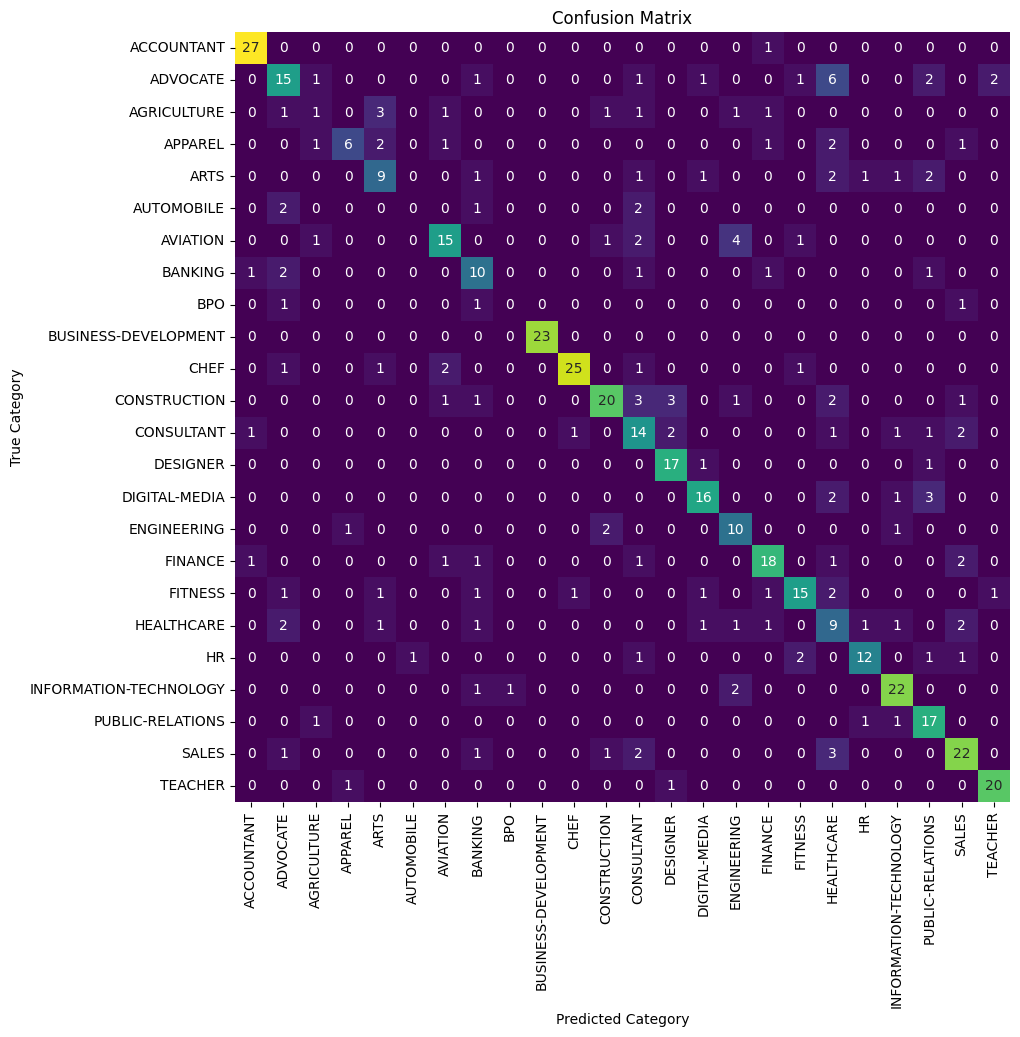

In [ ]:
# Generate classification report
print("Classification Report:")
print(classification_report(true_labels_decoded, predicted_labels_decoded_tl300))

conf_matrix_tl300 = confusion_matrix(true_labels_decoded, predicted_labels_decoded_tl300)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix_tl300, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='viridis', cbar=False)
plt.xlabel('Predicted Category')
plt.ylabel('True Category')
plt.title('Confusion Matrix')
plt.show()


## Final requirement of using state-of-the-art model

1. Transfer Learning with Pre-trained BERT Model
First, we'll use a pre-trained BERT model for transfer learning. This involves fine-tuning the pre-trained model on your specific dataset.

## State-of-The-Art Model (BERT)

In [ ]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel, BertConfig

In [ ]:
text_bert = data['cleaned_resume'].tolist()
labels_bert = data['encoded_category'].tolist()

text_bert = [" ".join(text) for text in text_bert]

In [ ]:
# Ensure texts are properly formatted (list of strings)
assert all(isinstance(text, str) for text in text_bert), "Texts must be a list of strings"

# Tokenize the texts
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized_texts = tokenizer(text_bert, padding=True, truncation=True, return_tensors='tf')
input_ids = tokenized_texts['input_ids']
attention_mask = tokenized_texts['attention_mask']

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Ensure `input_ids` and `attention_mask` are in a compatible format (NumPy array)
input_ids_np = input_ids.numpy()
attention_mask_np = attention_mask.numpy()

# Ensure `labels` is also a NumPy array
labels_np = np.array(labels_bert)

# Use `train_test_split` with NumPy arrays for `input_ids`
train_inputs, test_inputs, train_labels, test_labels = train_test_split(input_ids_np, labels_np, test_size=0.2)

# Similarly, split the `attention_mask` NumPy array
train_masks, test_masks, _, _ = train_test_split(attention_mask_np, labels_np, test_size=0.2)

In [ ]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

# Define a custom Keras layer that encapsulates the BERT model
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert = TFBertModel.from_pretrained('bert-base-uncased')

    def call(self, inputs):
        # BERT model returns a tuple (last_hidden_state, pooled_output, hidden_states, attentions)
        # For classification tasks, we are typically interested in the pooled_output
        return self.bert(inputs)[1]

In [ ]:
# Load the pre-trained BERT model as a custom layer
bert_layer = BertLayer()

# Define the model input
input_ids = Input(shape=(512,), dtype=tf.int32, name='input_ids')  # 512 is the max_length used during tokenization
attention_masks = Input(shape=(512,), dtype=tf.int32, name='attention_mask')  # Same shape as input_ids

# Get the output from the BERT layer
pooled_output = bert_layer([input_ids, attention_masks])

# Add a classification layer on top
classification_layer = Dense(len(set(labels_bert)), activation='softmax')(pooled_output)



# Construct the final model
model_bert = Model(inputs=[input_ids, attention_masks], outputs=classification_layer)

# Compile the model
optimizer = Adam(learning_rate=7e-5)
loss = SparseCategoricalCrossentropy(from_logits=True)
metric = SparseCategoricalAccuracy('accuracy')
model_bert.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Prepare training and validation data as a dictionary
train_data = {'input_ids': train_inputs, 'attention_mask': train_masks}
test_data = {'input_ids': test_inputs, 'attention_mask': test_masks}


# Train the model
model_bert.fit(train_data, train_labels, validation_data=(test_data, test_labels), \
          epochs=8, batch_size=8)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/8


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


249/249 [==============================] - 168s 409ms/step - loss: 2.6449 - accuracy: 0.2548 - val_loss: 1.9377 - val_accuracy: 0.4648
Epoch 2/8
249/249 [==============================] - 92s 370ms/step - loss: 1.7229 - accuracy: 0.5262 - val_loss: 1.7031 - val_accuracy: 0.5372
Epoch 3/8
249/249 [==============================] - 91s 365ms/step - loss: 1.4508 - accuracy: 0.5886 - val_loss: 1.5222 - val_accuracy: 0.5614
Epoch 4/8
249/249 [==============================] - 90s 362ms/step - loss: 1.0470 - accuracy: 0.7160 - val_loss: 1.6479 - val_accuracy: 0.5734
Epoch 5/8
249/249 [==============================] - 90s 361ms/step - loss: 0.8094 - accuracy: 0.7779 - val_loss: 1.5584 - val_accuracy: 0.6318
Epoch 6/8
249/249 [==============================] - 89s 358ms/step - loss: 0.5443 - accuracy: 0.8454 - val_loss: 1.6479 - val_accuracy: 0.6479
Epoch 7/8
249/249 [==============================] - 89s 357ms/step - loss: 0.3612 - accuracy: 0.8973 - val_loss: 1.5115 - val_accuracy: 0.6660
E

In [ ]:
model_bert.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 bert_layer_4 (BertLayer)    (None, 768)                  1094822   ['input_ids[0][0]',           
                                                          40         'attention_mask[0][0]']      
                                                                                            

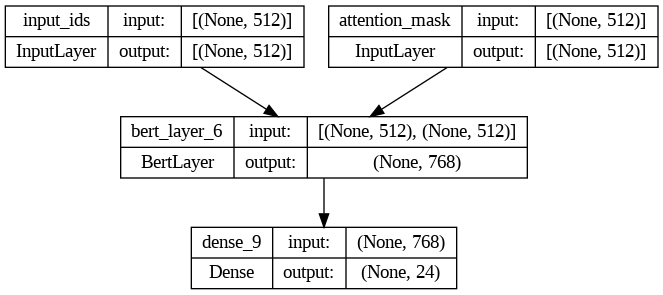

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_bert, to_file='model_bert_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
# Make predictions on the test data
predictions_bert = model_bert.predict(test_data, batch_size=8)


63/63 [==============================] - 19s 124ms/step


In [ ]:
predicted_labels_bert = np.argmax(predictions_bert, axis=1)

In [ ]:
# Calculate evaluation metrics
accuracy_bert = np.mean(predicted_labels_bert == test_labels)
print("Accuracy:", accuracy_bert)


Accuracy: 0.682092555331992


Classification Report:
                        precision    recall  f1-score   support

            ACCOUNTANT       0.88      0.95      0.91        22
              ADVOCATE       0.58      0.67      0.62        21
           AGRICULTURE       0.71      0.28      0.40        18
               APPAREL       1.00      0.45      0.62        22
                  ARTS       0.59      0.71      0.64        24
            AUTOMOBILE       0.50      0.14      0.22         7
              AVIATION       0.75      0.50      0.60        18
               BANKING       0.37      0.96      0.53        23
                   BPO       0.00      0.00      0.00         3
  BUSINESS-DEVELOPMENT       1.00      1.00      1.00        29
                  CHEF       0.96      0.85      0.90        27
          CONSTRUCTION       0.47      0.47      0.47        19
            CONSULTANT       0.55      0.78      0.65        27
              DESIGNER       0.86      0.83      0.84        23
         DIGITAL

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


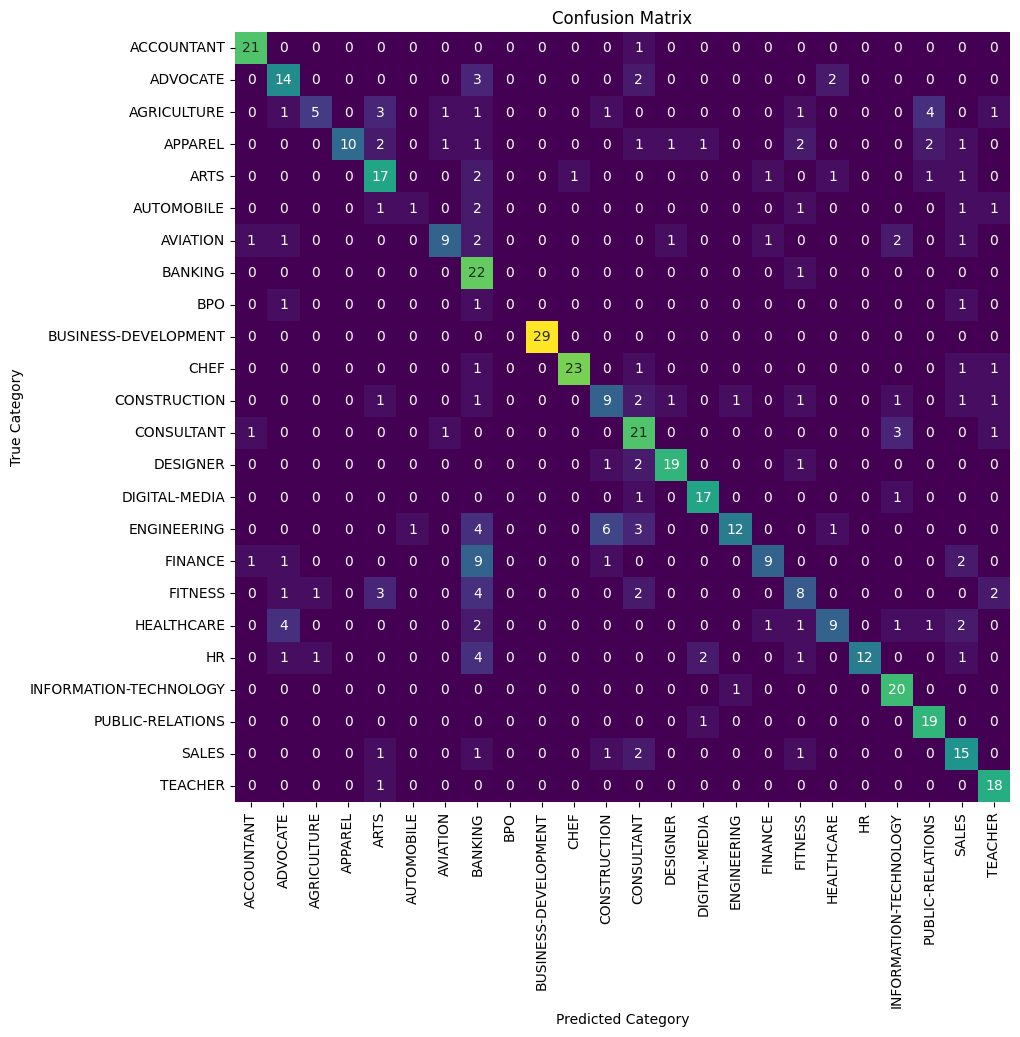

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Define a dictionary mapping encoded labels to their names
label_names = {0: 'ACCOUNTANT', 1: 'ADVOCATE', 2: 'AGRICULTURE', 3: 'APPAREL',
               4: 'ARTS', 5: 'AUTOMOBILE', 6: 'AVIATION', 7: 'BANKING',
               8: 'BPO', 9: 'BUSINESS-DEVELOPMENT', 10: 'CHEF', 11: 'CONSTRUCTION',
               12: 'CONSULTANT', 13: 'DESIGNER', 14: 'DIGITAL-MEDIA', 15: 'ENGINEERINT',
               16: 'FINANCE', 17: 'FITNESS', 18: 'HEALTHCARE', 19: 'HR',
               20: 'INFORMATION-TECHNOLOGY', 21: 'PUBLIC-RELATIONS', 22: 'SALES', 23: 'TEACHER'
               }  # Add all label names accordingly

# Convert test_labels and predicted_labels_bert to their corresponding names
test_labels_names = [label_names[label] for label in test_labels]
predicted_labels_bert_names = [label_names[label] for label in predicted_labels_bert]

# Generate classification report with label names
print("Classification Report:")
print(classification_report(test_labels_names, predicted_labels_bert_names))

# Generate confusion matrix with label names
conf_matrix_bert = confusion_matrix(test_labels_names, predicted_labels_bert_names)
print("Confusion Matrix:")
#print(conf_matrix_bert)
# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix_bert, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='viridis', cbar=False)
plt.xlabel('Predicted Category')
plt.ylabel('True Category')
plt.title('Confusion Matrix')
plt.show()
